## MLE computation

compute the MLE to check quality of estimates and code functionality.

In [15]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [2]:
using DataFrames, Optim, Plots

### create simulated data obs

In [3]:
# set some random system parameters
a_true = 1.1
n0_true = 2.3
noise = 1.0
M = 100

hprm = Src.Hyperprm(0.95, n0_true, a_true, 0.45, M, noise);

In [4]:
# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=true, t_end=100.0) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy


### experiment for single sample

In [8]:
# compute MLE
mle, success = Src.compute_mle(hprm, sol_true; t_fixed=true, t_end=100.0) # compute MLE
print("[a_mle, n0_mle] = $mle")

[a_mle, n0_mle] = [1.1152248888066647, 2.214707429101227]

In [6]:
# compute Fi evaluated at MLE and at true prm point
# compare both and see that Fi differs. Note that fi_mle must not necessarily be higher than fi_true

fi_mle = Src.compute_fi(mle, hprm, sol_true; t_fixed=true, t_end=500.0)
fi_true = Src.compute_fi([a_true,n0_true], hprm, sol_true; t_fixed=true, t_end=500.0)

print("fi_mle, fi_true = $fi_mle, $fi_true")

fi_mle, fi_true = 892.8992184119934, 940.6697888054434

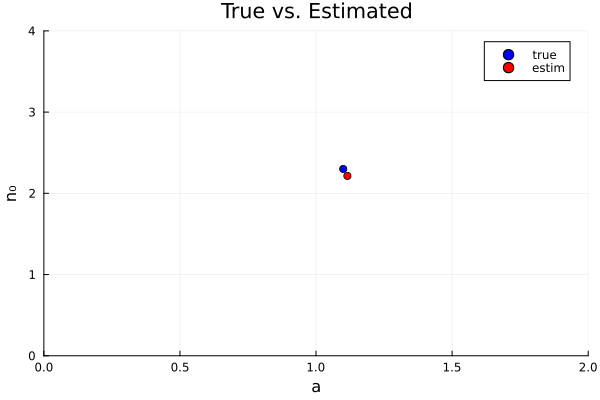

In [7]:
# plot true prm vs MLE
scatter([a_true], [n0_true], label = "true", color = :blue,xlabel = "a", ylabel = "n₀", xlims = (0, 2), ylims = (0, 4),legend = :topright,title = "True vs. Estimated")
scatter!([mle[1]], [mle[2]], label = "estim", color = :red)

I checked the corresponding log-likelihood plots for different points and noise levels and the MLEs visually fit the maxima of the respective log-likelihood functions.

### multiple restart opim

In [9]:
N = 20

20

In [ ]:
"""
    function mult_restart_mle(N::Int64, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

Perform Maximum Likelihood estimation for N different starting points. Goal is to find global minimum

# Inputs
    - `N::Int64`: number of restarts

# Returns
    - `Maxtrix`: initial values used in optimization
    - `Matrix`: computed MLEs
    - `Vector`: corresponding losses of MLEs
"""
function mult_restart_mle(N::Int64, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    # generate optim start pts
    inits = hcat(2 .* rand(N), 4 .* rand(N))

    # store mles and corresponding loss
    mle_vals = zeros(N, 2)
    mle_loss, inits_loss = zeros(N), zeros(N)

    for i in 1:size(inits, 1)
        pt = inits[i,:]
        result = optimize(x -> - Src.compute_ll(x, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step), pt)
        #display(result)
        mle_vals[i,:] = Optim.minimizer(result)
        mle_loss[i] =  Optim.minimum(result)
        inits_loss[i] = -Src.compute_ll(pt, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step)
    end

    # extract best
    best_loss, best_loss_ind = findmin(mle_loss)

    return inits, inits_loss, mle_vals, mle_loss, best_loss_ind
end

inits, inits_loss, mles, losses, best_loss_ind = mult_restart_mle(N, hprm, sol_true, t_fixed=true, t_end=100.0);

MethodError: MethodError: no method matching mult_restart_mle(::Int64, ::Main.Src.Hyperprm, ::DataFrame; t_fixed::Bool, t_end::Float64)
The function `mult_restart_mle` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  mult_restart_mle(::Int64, !Matched::Main.Src.Hyperprm, ::DataFrame; t_fixed, t_end, t_step)
   @ Main.Src c:\Users\lisah\Documents\Repos\ma-code\src\data.jl:71


In [119]:
# extract best
best_loss, best_loss_ind = findmin(losses)
best_mle = mles[best_loss_ind, :];

#### Plots

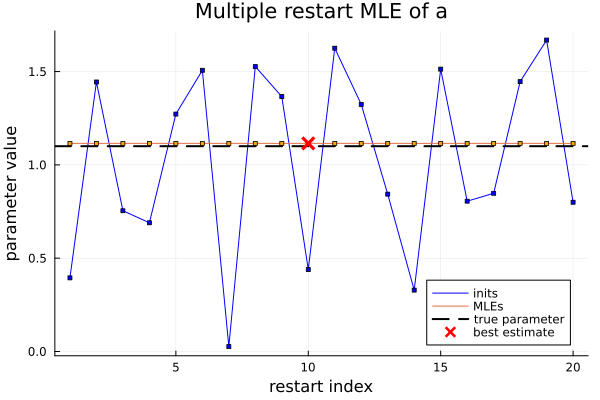

In [12]:
# plot inits vs. mles
plot(inits[:,1], label="inits", title="Multiple restart MLE of a",color=:blue, ylabel="parameter value", xlabel="restart index")
plot!(mles[:,1], label="MLEs")
hline!([hprm.a], linestyle=:dash, linewidth=2, color=:black,  label="true parameter")
scatter!(1:N, inits[:,1], markershape=:square, markersize=2, color=:blue, label="")
scatter!(1:N, mles[:,1], markershape=:square, markersize=2, color=:orange, label="")
scatter!([best_loss_ind], [mles[best_loss_ind, 1]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="best estimate")


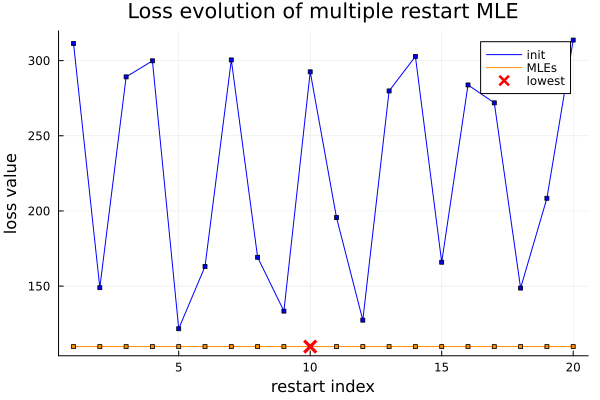

In [14]:
# plot losses
plot(inits_loss, label="init", title="Loss evolution of multiple restart MLE",color=:blue, ylabel = "loss value", xlabel="restart index")
plot!(losses, label="MLEs", color=:darkorange)
scatter!(1:N, inits_loss, markershape=:square, markersize=2, color=:blue, label="")
scatter!(1:N, losses, markershape=:square, markersize=2, color=:darkorange, label="")
scatter!([best_loss_ind], [losses[best_loss_ind]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="lowest")

I tried out different regimes of a.
Identifiability differs depending on whether a is left or right to the bifurcation point. 
If a right of bifurcation point, there appears to be another local minimum -> not practically identifiable!

TODO:
- plot profile likelihood
- check loss: why are the values so high? and so different -> there seems to be a local minimum far away
- why are values positive? -> makes sense: ll is negative, thus nll is positive
- why is loss so high? normal?